# Facial Expression Recognition CHALLENGE

## Pilot

In [135]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid

## Data

In [129]:
# Define the path to your dataset folder
dataset_path = './archive/'
train_folder_path = './archive/train/'

In [132]:
# Define emotion labels and other variables
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
emotion_labels = [subfolder for subfolder in os.listdir(train_folder_path) if os.path.isdir(os.path.join(train_folder_path, subfolder))]
print(emotion_labels)

num_classes = len(emotion_labels)

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


In [138]:
# Create a list to store the information
data = []

# Iterate through each subfolder
for subfolder in emotion_labels:
    subfolder_path = os.path.join(train_folder_path, subfolder)
    num_images = len(os.listdir(subfolder_path))
    data.append({'Emotion': subfolder, 'Quantity': num_images})

# Create a DataFrame from the data
df = pd.DataFrame(data)
df

Emotion  Quantity
0     happy      7215
1       sad      4830
2      fear      4097
3  surprise      3171
4   neutral      4965
5     angry      3995
6   disgust       436

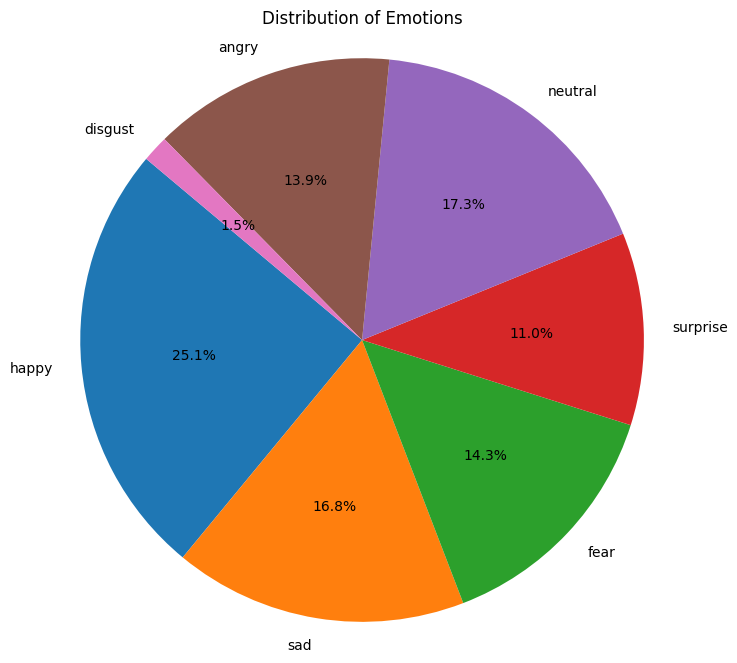

In [139]:
# Create a pie chart
plt.figure(figsize = (8, 8))
plt.pie(df['Quantity'], labels = df['Emotion'], autopct = '%1.1f%%', startangle = 140)
plt.title('Distribution of Emotions')
plt.axis('equal')  
plt.show()

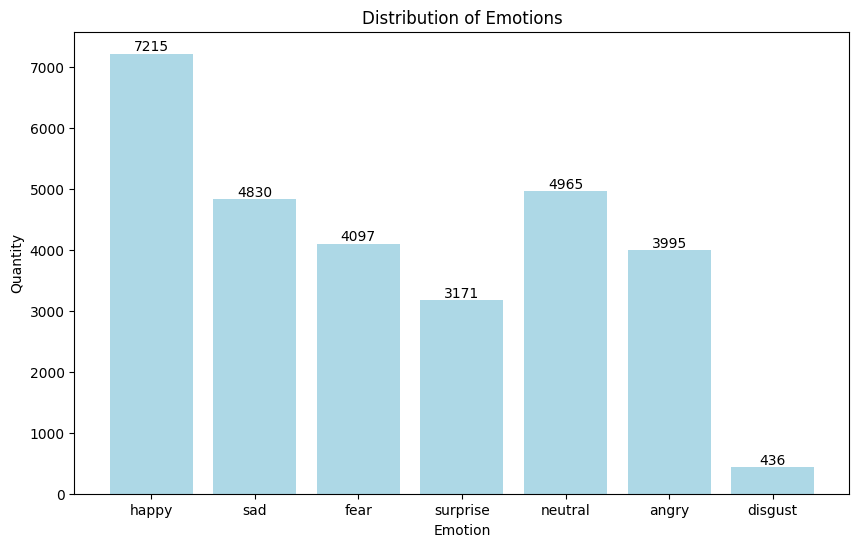

In [175]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(df['Emotion'], df['Quantity'], color='lightblue')

plt.xlabel('Emotion')
plt.ylabel('Quantity')
plt.title('Distribution of Emotions')

for i, value in enumerate(df['Quantity']):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()

In [125]:
# Define transforms for data preprocessing and augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])  # Normalize to [0, 1]?
])

In [126]:
# Define a custom dataset class
class FacialDataset(Dataset):
    def __init__(self, root_dir, labels, transform = transform):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = labels
        self.image_paths = []
        self.label_indices = []

        for label_idx, emotion in enumerate(labels):
            emotion_path = os.path.join(self.root_dir, 'train', emotion)
            image_files = os.listdir(emotion_path)
            
            for image_file in image_files:
                image_path = os.path.join(emotion_path, image_file)
                self.image_paths.append(image_path)
                self.label_indices.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_idx = self.label_indices[idx]
        
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        
        label = label_idx
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def check_normalized_pixel_range(self, transform):
        for idx, (image_path) in enumerate(self.image_paths):
            
            image = Image.open(image_path).convert('L')
            transformed_image = transform(image)
            transformed_image_array = transformed_image.numpy()  # Convert PyTorch tensor to NumPy array
            
            label = self.label_indices[idx]  
            
            print("Image:", image_path)
            print("Label:", label)
            print("Minimum normalized pixel value:", np.min(transformed_image_array))
            print("Maximum normalized pixel value:", np.max(transformed_image_array))
            print("--------")

In [169]:
def show_batch(images, labels, emotion_labels):
    num_images = images.shape[0]
    num_rows = int(np.ceil(num_images / 8 / 2))
    
    fig, axes = plt.subplots(num_rows, 8, figsize = (10, 1 * num_rows))
    
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            ax.imshow(np.squeeze(images[i].numpy()), cmap='gray')  # images[i] is expected to have shape (C, H, W)
            ax.set_title(emotion_labels[labels[i].item()])
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

Sorted emotion labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


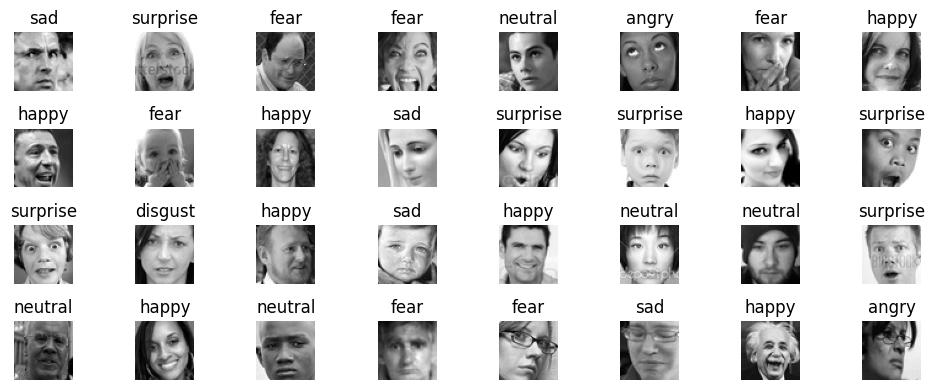

In [170]:
### Alternative Data Loader ###

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the path to your dataset folder
dataset_path = './archive/'
train_folder_path = './archive/train/'
emotion_labels = [subfolder for subfolder in os.listdir(train_folder_path) if os.path.isdir(os.path.join(train_folder_path, subfolder))]
emotion_labels.sort()
print("Sorted emotion labels:", emotion_labels)

# Directory paths
train_dir = './archive/train/'
test_dir = './archive/test/'

# Data transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5]) 
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Datasets
train_dataset = ImageFolder(root = train_dir, transform = train_transform)
test_dataset = ImageFolder(root = test_dir, transform = test_transform)
print(train_dataset.class_to_idx)

# Split the data into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
batch_size = 64
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = False)

# Visualize a batch of augmented training images
data_iter = iter(train_loader)
images, labels = next(data_iter)
show_batch(images, labels, emotion_labels)
###############################

torch.Size([64, 1, 48, 48])
tensor([4, 6, 6, 4, 3, 0, 2, 6, 5, 2, 3, 2, 3, 4, 3, 4, 4, 3, 0, 2, 3, 5, 5, 6,
        3, 2, 2, 3, 3, 3, 2, 2, 5, 0, 4, 2, 6, 3, 0, 6, 5, 6, 4, 2, 3, 2, 3, 2,
        6, 0, 4, 3, 5, 3, 5, 0, 0, 4, 3, 2, 3, 0, 2, 0])
neutral


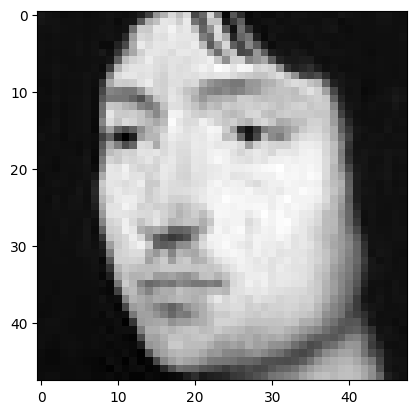

In [165]:
i = 0
image, label = next(iter(train_loader))
print(image.shape)
print(label)
print(emotion_labels[label[i]])
plt.imshow(np.transpose(image[i], (1, 2, 0)), cmap = 'gray')

In [127]:
# Create datasets and data loaders
facial_dataset = FacialDataset(dataset_path, emotion_labels)
train_size = int(0.9 * len(facial_dataset))
val_size = len(facial_dataset) - train_size
train_dataset, val_dataset = random_split(facial_dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

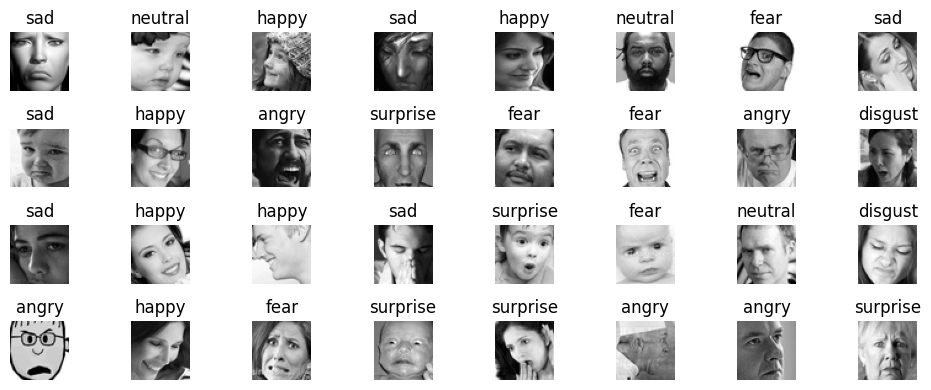

In [171]:
# Visualize a batch of augmented training images
data_iter = iter(train_loader)
images, labels = next(data_iter)
show_batch(images, labels, emotion_labels)

### Sanity check

In [119]:
from PIL import Image

# Load an example image
image_path = './archive/train/fear/Training_10018621.jpg'
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Convert PIL image to NumPy array
image_array = np.array(image)

# Print the minimum and maximum pixel values
print("Shape:", image_array.shape)
print("Minimum pixel value:", np.min(image_array))
print("Maximum pixel value:", np.max(image_array))

Shape: (48, 48)
Minimum pixel value: 12
Maximum pixel value: 255


In [123]:
# Call the check_normalized_pixel_range method
facial_dataset.check_normalized_pixel_range(transform)

Image: ./archive/train/angry/Training_35668808.jpg
Label: 0
Minimum normalized pixel value: -1.0
Maximum normalized pixel value: 0.90588236
--------
Image: ./archive/train/angry/Training_92439792.jpg
Label: 0
Minimum normalized pixel value: -1.0
Maximum normalized pixel value: 1.0
--------
Image: ./archive/train/angry/Training_41634629.jpg
Label: 0
Minimum normalized pixel value: -0.8901961
Maximum normalized pixel value: 0.9372549
--------
Image: ./archive/train/angry/Training_78260987.jpg
Label: 0
Minimum normalized pixel value: -0.9372549
Maximum normalized pixel value: 0.4039216
--------
Image: ./archive/train/angry/Training_23736738.jpg
Label: 0
Minimum normalized pixel value: -1.0
Maximum normalized pixel value: 0.94509804
--------
Image: ./archive/train/angry/Training_16211575.jpg
Label: 0
Minimum normalized pixel value: -0.9372549
Maximum normalized pixel value: 1.0
--------
Image: ./archive/train/angry/Training_99062607.jpg
Label: 0
Minimum normalized pixel value: -0.88235295


## Model

In [65]:
INIT_CHANNELS = 32

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout(0.2)
        )
    
    def forward(self, x):
        return self.conv(x)

class FERModel(nn.Module):
    def __init__(self, num_classes):
        super(FERModel, self).__init__()
        self.conv1 = ConvBlock(in_channels = 1, out_channels = INIT_CHANNELS)
        self.conv2 = ConvBlock(in_channels = INIT_CHANNELS, out_channels = 2 * INIT_CHANNELS)
        self.conv3 = ConvBlock(in_channels = 2 * INIT_CHANNELS, out_channels = 4 * INIT_CHANNELS)
        self.fc1 = nn.Linear(4 * INIT_CHANNELS * 6 * 6, 512)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.fc1(x)
        x = self.dropout(x)
        x = nn.functional.softmax(x)
        x = self.fc2(x)
        x = nn.functional.softmax(x)
        
        return x

In [66]:
# Instantiate the FERModel
num_classes = len(emotion_labels)
fer_model = FERModel(num_classes)

In [67]:
# Define hyperparameters
num_epochs = 10
learning_rate = 0.001

In [68]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fer_model.parameters(), lr = learning_rate)

In [178]:
# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [73]:
# Instantiate the model
model = FERModel(num_classes = num_classes).to(device)

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    val_accuracy = correct_predictions / total_predictions
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2%}")

print("Training finished.")